In [1]:
#Note if you are using google colab - please go to Runtime -> Change runtime type  and select GPU as Hardware accelerator. This will make notebook run faster.
#github link: https://github.com/sanigam/BERT_Medium

#Install following libraries before first run. For subsequent runs, you may comment these
!pip install tensorflow==2.1.0
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install sentencepiece

#Importing Required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from bert import bert_tokenization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Tensorflow version
print("Tensorflow Version:", tf.__version__)



Tensorflow Version: 2.1.0


In [2]:
#Loading Tweets Data, you can load from file in your computer or from github link. 
#For a different use case, you can load different file in similar format

#df = pd.read_csv('tweets.csv') #From your computer
df = pd.read_csv('https://raw.githubusercontent.com/sanigam/BERT_Medium/master/tweets.csv') #From github link


print ( f'Data Shape: {df.shape} ') #Number of rows and column in data-frame


Data Shape: (7613, 2) 


,text,target
4150,Owner of Chicago-Area Gay Bar Admits to Arson ...,0
5118,@CIA hey you guy's i stopped a massacre so you...,0



Sample Non Disaster tweet (target = 0):
-------------------------------
Listen to this hit song. A summer Bomb full of positive energy and youth
Did you like it?
https://t.co/2LiWkJybE9 
#Norge2040

Sample Tweet indicating Disaster (target = 1):
--------------------------------------
Still can't get over the thunderstorm/tornado we were woken up to yesterday. Half the street is still in the dark! http://t.co/Y8h5v1j2y7

Tweets distribution for Disaster Tweets (1)  and Non-Disaster Tweets (0)
------------------------------------------------------------------------


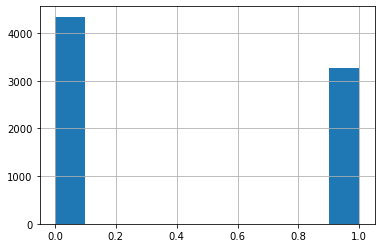

In [3]:
#Optional Step: Looking into data
display(df.sample(2)) #Sample rows of dataframe

print ( '\nSample Non Disaster tweet (target = 0):\n-------------------------------')
print ( df[df['target']==0].text.values[0] )

print ( '\nSample Tweet indicating Disaster (target = 1):\n--------------------------------------')
print ( df[df['target']==1].text.values[0] )

print ( '\nTweets distribution for Disaster Tweets (1)  and Non-Disaster Tweets (0)\n------------------------------------------------------------------------')
df['target'].hist() ;

In [4]:
# Splitting data into test and training
df_train, df_test = train_test_split( df , test_size=0.33, random_state=42)

print( f'Training Data Shape: {df_train.shape}  ,  Test Data Shape:  {df_test.shape}') # Rows/Cols in train/test data

Training Data Shape: (5100, 2)  ,  Test Data Shape:  (2513, 2)


In [5]:
#Loading BERT Standard model (Pretrained Model on Wikipedia and Book Corpus)
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True, name = 'keras_bert_layer' )

#Getting vocab file from bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() 

do_lower_case = True  # For uncased model it will True 

#Defining tokenizer object which will be used to tokenize text before feeding to bert
tokenizer_for_bert = bert_tokenization.FullTokenizer(vocab_file, do_lower_case) #Tokenizer to tokenize input text

print ( '\nLength of vocab in our tokenizer : ' , len(tokenizer_for_bert.vocab) ) #BERT vocab has around 30K words


Length of vocab in our tokenizer :  30522


In [6]:
#Function to encode text in format to feed to BERT

def encode_text_for_bert (texts, tokenizer_for_bert, max_len=512):
    ''' This function is to encode data for inputting into BERT model
    Parameters:
    texts - List of texts to encode
    tokenizer_for_bert - Tokenizer to be used to convert text into tokens
    max_len - Maximum length of text. It can have maximum value as 512
    Return: Tupple of 3 numpy arrays 
    1) Token Ids padded with 0s to make length as max_len.  
    2) Array where we have 1 for actual tokens and 0 for padding tokens
    3) Array of 0s to indicate that token belongs to 1st sentence (chunk of text). There is no 2nd sentence here.
    '''
    all_token_ids = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        tokens = tokenizer_for_bert.tokenize(text) #Tokenizing using Bert tokenizer
            
        tokens = tokens[:max_len-2] # Truncating number of tokens to max_len -2, Reduced extra 2 to add special tokens
        
        input_sequence = ["[CLS]"] + tokens + ["[SEP]"]  # [CLS] and [SEP] are special tokens to be added into input text
        
        pad_len = max_len - len(input_sequence) # Spaces to fill with 0s to make each sequence equal to max_len
        
        token_ids = tokenizer_for_bert.convert_tokens_to_ids(input_sequence)   #Converting tokens to token ids 
       
        token_ids += [0] * pad_len  #Padding token ids with 0s
        
        pad_masks = [1] * len(input_sequence) + [0] * pad_len # 1 where we have sentence tokens and 0 otherwise
        
        segment_ids = [0] * max_len # Segment ids are all 0 to indicate it is part of sentence 1. There is no sentence 2 here
        
        all_token_ids.append(token_ids)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_token_ids), np.array(all_masks), np.array(all_segments)


In [7]:
#Optional Step: This is just to understand input/output of function encode_text_for_bert
test_text =  "Welcome to  BERT session "

print ("Test text after tokenization: " ,  ["[CLS]"] + tokenizer_for_bert.tokenize( test_text)  + ["[SEP]"] )

print ("Test text after encoding: " ,encode_text_for_bert ( [test_text], tokenizer_for_bert, 7 ) ) # Pl Note id 101 is for token [CLS] and 102 for token [SEP]

Test text after tokenization:  ['[CLS]', 'welcome', 'to', 'bert', 'session', '[SEP]']
Test text after encoding:  (array([[  101,  6160,  2000, 14324,  5219,   102,     0]]), array([[1, 1, 1, 1, 1, 1, 0]]), array([[0, 0, 0, 0, 0, 0, 0]]))


In [8]:
#Creating BERT  Model 
def bert_model_creation (bert_layer, max_len=512, model_type = 'Classification', num_classes = 2):
    '''This function is to create BERT model for Classification or Regession Task
    Parameters:
    model_type = 'Classification' for classification task or 'Regression' for regression task. 
    num_classes = Number of classes in classification task. Value of 2 means binary classification. More than 2 for multiclass classification.
                  For regression, num_classes parameter is ignored.
    Return: Deep Learning Model
    Important: You may add additional dense layers in place holder provided as "***PLACEHOLDFER FOR ADDITIONAL LAYERS****"
    '''   
    #Input to bert layer
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    #Output from bert layer
    bert_layer_out = bert_layer([input_word_ids, input_mask, segment_ids]) # Python list of 2 tensors with shape (batch_size, 768) and (batch_size, max_len, 768)
    
    #Extrating Embedding for CLS token comming out of bert layer. Note CLS is the first token
    cls_out = bert_layer_out[1][:,0,:] # Getting hidden-state of 1st tokens from second tensor in bert_layer_out, Tensor shape - (batch size, 768) 
    
    
    #***PLACEHOLDFER FOR ADDITIONAL LAYERS****. 
    #Add more layers here if you want. See example below
    #cls_out = Dropout(.25) (cls_out)
    #cls_out = Dense(500, activation='relu')(cls_out) 
    
    
    
    #Defines last layer depending on model type and  number of classes. Activation function is used depending on model_type and num_classes
    if model_type == 'Classification' :
        if num_classes == 2 :
            out = Dense(1, activation='sigmoid')(cls_out)     # ** For Binary classification, use sigmoid activation
        else:    
            out = Dense(num_classes, activation='softmax')(cls_output) # For Multi Class classification, use softmax activation
    else:
        out = Dense(1, activation='linear')(cls_out)     # For regression, use linear activation
    
    #Model creation using inputs and output
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out, name='deeplearning_bert__model')
    
    
    
    learning_rate = 2e-6 # modify learning rate,as needed
    
    #Compiles Model depending on model type and number of classes. Loss function as well as metrics is used accordingly
    if model_type == 'Classification' :
        if num_classes == 2 :
            model.compile(Adam(lr= learning_rate), loss='binary_crossentropy', metrics=['acc']) # ** For Binary classification
        else:
            model.compile(Adam(lr= learning_rate), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy']) # For Multi Class classification 
    else:
        model.compile(Adam(lr= learning_rate), loss='mse', metrics=['mse']) # For Regression
        
    return model

In [9]:
max_len = 30 #Max length of text input to model. It can go up to 512. Keeping it small to run it faster

In [10]:
#Building Classification Model
#modify values of model_type and num_classes as per need
model = bert_model_creation(bert_layer, max_len=max_len, model_type = 'Classification', num_classes = 2) #binary classification as num_classes = 2

#Model Summary. Pl note, there are ~109 Million parameters as it is BERT standard model
model.summary() 

Model: "deeplearning_bert__model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
keras_bert_layer (KerasLayer)   [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask

In [11]:
#Encoding Training Data for BERT.  If you want  preprocessing/cleaning of input text, it should be done before this step
train_input = encode_text_for_bert(df_train['text'].values, tokenizer_for_bert, max_len= max_len)

#Output variable as 0s or 1s for binary classification. It can have more distinct values for multi-class classification or continous values for regression
y_train = df_train['target'].values 

In [12]:
#Optional step: Checking accuracy on train tweets before fine-tuning so that we can see improvement by fine tuning
accuracy_score( y_train, np.round(model.predict(train_input)).flatten() )

0.4264705882352941

In [13]:
#Model Training (Fine-tuning for tweets classification)
epochs = 2       #Modify as neded
batch_size = 32  #Modify as needed
train_history = model.fit(train_input, y_train ,epochs= epochs,batch_size= batch_size, verbose=1)

Train on 5100 samples
Epoch 1/2
5100/5100 [==============================] - 79s 15ms/sample - loss: 0.5517 - acc: 0.7235
Epoch 2/2
5100/5100 [==============================] - 62s 12ms/sample - loss: 0.3968 - acc: 0.8278


In [14]:
#Checking accuracy on train tweets
accuracy_score( y_train, np.round(model.predict(train_input)) )

0.8572549019607844

In [15]:
#Encoding test data into BERT Format. If you have  preprocessing/cleaning of input text, it should be done before this step

test_input = encode_text_for_bert(df_test['text'].values, tokenizer_for_bert, max_len= max_len)
y_test = df_test['target'].values

#Checking accuracy on test tweets. You may be able to improve it by taking bigger length of text, more epochs or by adding more dense layers into the model
accuracy_score( y_test, np.round(model.predict(test_input)) )

0.8265021886191802

In [16]:
#Running model on single text. Validating model for non-disaster text

tweet = "We have a great data symposium today."

prediction = model.predict (  encode_text_for_bert ( [tweet], tokenizer_for_bert, max_len=max_len) ) 
print('Tweet Text: ', tweet)
print ( 'Tweet Type: ', np.where(  prediction >= .5 , "Disaster", "Non Disaster" ) , '   Score:',  prediction)

Tweet Text:  We have a great data symposium today.
Tweet Type:  [['Non Disaster']]    Score: [[0.0891896]]


In [17]:
#Running model on single text. Validating model for disaster text

tweet = "It is a terrorist attack. Take shelter  "

prediction = model.predict (  encode_text_for_bert ( [tweet], tokenizer_for_bert, max_len=max_len) ) 
print('Tweet Text: ', tweet)
print ( 'Tweet Type: ', np.where(  prediction >= .5 , "Disaster", "Non Disaster" ) , '   Score:',  prediction)

Tweet Text:  It is a terrorist attack. Take shelter  
Tweet Type:  [['Disaster']]    Score: [[0.6896698]]
